# DETECTING PSYCHOLOGICAL STATE OF CHILDREN BY HTP DRAWINGS

In [57]:
import os
import pandas as pd
import fitz 
from PIL import Image
import shutil

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from collections import Counter
import shutil

import tensorflow as tf
import keras
import keras.utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing import image

## Load Dataset

In [2]:
dataset_folder = 'HTPDataset'

In [3]:
pdf_files = [f for f in os.listdir(dataset_folder) if f.endswith('.pdf')]
print("List of PDF files:")
for pdf_file in pdf_files:
    print(pdf_file)

List of PDF files:
201802_MBC.pdf
522019_GY.pdf
202016_NEŞ.pdf
201720_ERD.pdf
142019_BST.pdf
201664_MMŞ.pdf
152017_MBT.pdf
532019_MT.pdf
302016_YG.pdf
992016_OFB.pdf
992017_EK.pdf
222016_KAM.pdf
402016_NG.pdf
212016_MG.pdf
162019_EA.pdf
562019_YD.pdf
242016_ZK.pdf
262016_BGÖ.pdf
552017_KYA.pdf
122018_AST.pdf
201755_GA.pdf
582019_ZD.pdf
132018_BMY.pdf
142018_CEÜ.pdf
582017_RZİ.pdf
201759_BK.pdf
512018_FZA.pdf
201803_SD.pdf
162017_MK.pdf
192019_ES.pdf
542018_RRA.pdf
201839_MŞY.pdf
192016_ENÇ.pdf
112018_AG.pdf
132019_BA.pdf
162016_EMA.pdf
122019_AAA.pdf
172016_AK.pdf
562017_LÇ.pdf
532017_FŞK.pdf
592019_MB.pdf
112016_YG.pdf
252016_EDB.pdf
172019_EB.pdf
201809_OMB.pdf
222019_ATS.pdf
152019_CEÖ.pdf
122017_DF.pdf
182019_EHT.pdf
152016_HBK.pdf
282016_OMB.pdf
512019_FAG.pdf
201815_EBK.pdf
412016_Nİ.pdf
232019_BBG.pdf
472019_ZAA.pdf
992018_ENŞ.pdf
102016_EY.pdf
552019_RE.pdf
312016_AB.pdf
162018_EA.pdf
201738_AŞ.pdf
982018_YEK.pdf
522018_HP.pdf
142017_EM.pdf
542019_MÖ.pdf
532018_HC

In [4]:
pdf_page_counts = {}
for pdf_file in pdf_files:
    pdf_path = os.path.join(dataset_folder, pdf_file)
    pdf_document = fitz.open(pdf_path)
    num_pages = pdf_document.page_count
    pdf_page_counts[pdf_file] = num_pages
    pdf_document.close()
print("Number of pages in each PDF file:")
for pdf_file, num_pages in pdf_page_counts.items():
    print(f"{pdf_file}: {num_pages} pages")

Number of pages in each PDF file:
201802_MBC.pdf: 5 pages
522019_GY.pdf: 5 pages
202016_NEŞ.pdf: 5 pages
201720_ERD.pdf: 5 pages
142019_BST.pdf: 5 pages
201664_MMŞ.pdf: 10 pages
152017_MBT.pdf: 10 pages
532019_MT.pdf: 5 pages
302016_YG.pdf: 4 pages
992016_OFB.pdf: 4 pages
992017_EK.pdf: 6 pages
222016_KAM.pdf: 5 pages
402016_NG.pdf: 5 pages
212016_MG.pdf: 5 pages
162019_EA.pdf: 5 pages
562019_YD.pdf: 5 pages
242016_ZK.pdf: 5 pages
262016_BGÖ.pdf: 5 pages
552017_KYA.pdf: 3 pages
122018_AST.pdf: 5 pages
201755_GA.pdf: 7 pages
582019_ZD.pdf: 5 pages
132018_BMY.pdf: 5 pages
142018_CEÜ.pdf: 5 pages
582017_RZİ.pdf: 5 pages
201759_BK.pdf: 5 pages
512018_FZA.pdf: 5 pages
201803_SD.pdf: 5 pages
162017_MK.pdf: 8 pages
192019_ES.pdf: 5 pages
542018_RRA.pdf: 5 pages
201839_MŞY.pdf: 6 pages
192016_ENÇ.pdf: 5 pages
112018_AG.pdf: 5 pages
132019_BA.pdf: 5 pages
162016_EMA.pdf: 5 pages
122019_AAA.pdf: 5 pages
172016_AK.pdf: 5 pages
562017_LÇ.pdf: 4 pages
532017_FŞK.pdf: 5 pages
592019_MB.pdf:

## Dataset Preparation

In [5]:
img_dataset = 'HTPImages'
if not os.path.exists(img_dataset):
    os.makedirs(img_dataset)

In [6]:
pdf_files = [f for f in os.listdir(dataset_folder) if f.endswith('.pdf')]

for pdf_file in pdf_files:
    pdf_path = os.path.join(dataset_folder, pdf_file)
    pdf_document = fitz.open(pdf_path)
    
    base_name = os.path.splitext(pdf_file)[0]
    
    for page_num in range(pdf_document.page_count):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap()
        
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img_filename = f"{base_name}_{page_num + 1}.jpg"
        img_path = os.path.join(img_dataset, img_filename)
        img.save(img_path, "JPEG")
    
    pdf_document.close()

print("PDF to image conversion completed.")

PDF to image conversion completed.


In [7]:
def extract_metadata(filename):
    parts = os.path.splitext(filename)[0].split('_')
    id = parts[0]
    patient_name = '_'.join(parts[1:-1])
    page_number = parts[-1]
    return id, patient_name, page_number

image_files = [f for f in os.listdir(img_dataset) if f.endswith('.jpg')]

In [8]:
'''
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    img_filename = image_files[i]
    img_path = os.path.join(img_dataset, img_filename)
    img = Image.open(img_path)
    
    id, patient_name, page_number = extract_metadata(img_filename)
    
    axes[i].imshow(img)
    axes[i].set_title(f"ID: {id}\nPatient Name: {patient_name}\nPage Number: {page_number}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
'''

'\nnum_samples = 5\nfig, axes = plt.subplots(1, num_samples, figsize=(15, 5))\n\nfor i in range(num_samples):\n    img_filename = image_files[i]\n    img_path = os.path.join(img_dataset, img_filename)\n    img = Image.open(img_path)\n    \n    id, patient_name, page_number = extract_metadata(img_filename)\n    \n    axes[i].imshow(img)\n    axes[i].set_title(f"ID: {id}\nPatient Name: {patient_name}\nPage Number: {page_number}")\n    axes[i].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

In [9]:
ids = []
patient_names = []
page_numbers = []
patient_ids = []

for img_filename in image_files:
    id, patient_name, page_number = extract_metadata(img_filename)
    ids.append(id)
    patient_names.append(patient_name)
    page_numbers.append(page_number)
    patient_ids.append(f"{id}_{patient_name}")

df = pd.DataFrame({
    'image_file': image_files, 
    'ID': ids,
    'patient_name': patient_names,
    'page_number': page_numbers,
    'patient_Identifier': patient_ids
})

unique_patient_ids = {identifier: idx+1 for idx, identifier in enumerate(sorted(set(patient_ids)))}
df['patient_ID'] = df['patient_Identifier'].map(unique_patient_ids)
df = df.drop(columns=['patient_Identifier'])

df

,image_file,ID,patient_name,page_number,patient_ID
0,992016_OFB_1.jpg,992016,OFB,1,81
1,512017_ES_3.jpg,512017,ES,3,61
2,201931_REG_2.jpg,201931,REG,2,44
3,122019_AAA_1.jpg,122019,AAA,1,8
4,202016_NEŞ_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,201759_BK_3.jpg,201759,BK,3,35
446,512020_ARÖ_4.jpg,512020,ARÖ,4,64
447,522018_HP_5.jpg,522018,HP,5,65
448,112016_YG_5.jpg,112016,YG,5,2


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_file    450 non-null    object
 1   ID            450 non-null    object
 2   patient_name  450 non-null    object
 3   page_number   450 non-null    object
 4   patient_ID    450 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 17.7+ KB


In [11]:
for img_filename in image_files:
    old_path = os.path.join(img_dataset, img_filename)
    id, patient_name, page_number = extract_metadata(img_filename)
    new_filename = f"{df[df['image_file'] == img_filename]['patient_ID'].iloc[0]}_{page_number}.jpg"
    new_path = os.path.join(img_dataset, new_filename)
    os.rename(old_path, new_path)
    df.loc[df['image_file'] == img_filename, 'image_file'] = new_filename

df

,image_file,ID,patient_name,page_number,patient_ID
0,81_1.jpg,992016,OFB,1,81
1,61_3.jpg,512017,ES,3,61
2,44_2.jpg,201931,REG,2,44
3,8_1.jpg,122019,AAA,1,8
4,45_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,35_3.jpg,201759,BK,3,35
446,64_4.jpg,512020,ARÖ,4,64
447,65_5.jpg,522018,HP,5,65
448,2_5.jpg,112016,YG,5,2


In [12]:
xlsx_path = 'HTPDataset/patient_info.xlsx'
df_excel = pd.read_excel(xlsx_path)
df_excel.head()

,ID,Initials,Gen,Age,CB_Ex_R,CB_Anx_R,CB_Dep_R,WISC_TOZP_SP,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,102016,EY,1,7,12.0,4.0,5.0,90.0,NaN,NaN,We consider only children with IQ equal or abo...
1,112016,YG,0,9,3.0,5.0,3.0,NaN,NaN,NaN,We consider only school age children: 6-12 yea...
2,112018,AG,1,8,4.0,8.0,7.0,62.0,Low IQ: ignore the child,NaN,NaN
3,112019,AA,1,11,10.0,3.0,1.0,88.0,NaN,NaN,NaN
4,122016,TO,0,8,6.0,3.0,6.0,136.0,NaN,NaN,NaN


In [13]:
df_excel = df_excel.drop(columns=['Initials','Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])
df_excel = df_excel.rename(columns={'Gen': 'sex', 'Age': 'age', 'CB_Ex_R': 'externalising_score', 'CB_Anx_R':'anxious_score', 'CB_Dep_R':'depressive_score', 'WISC_TOZP_SP':'iq_score'})
df_excel

,ID,sex,age,externalising_score,anxious_score,depressive_score,iq_score
0,102016,1,7,12.0,4.0,5.0,90.0
1,112016,0,9,3.0,5.0,3.0,NaN
2,112018,1,8,4.0,8.0,7.0,62.0
3,112019,1,11,10.0,3.0,1.0,88.0
4,122016,0,8,6.0,3.0,6.0,136.0
...,...,...,...,...,...,...,...
79,982018,1,6,9.0,8.0,5.0,85.0
80,992016,1,6,10.0,7.0,4.0,96.0
81,992017,1,7,5.0,2.0,1.0,151.0
82,992018,0,10,4.0,4.0,0.0,65.0


In [14]:
df

,image_file,ID,patient_name,page_number,patient_ID
0,81_1.jpg,992016,OFB,1,81
1,61_3.jpg,512017,ES,3,61
2,44_2.jpg,201931,REG,2,44
3,8_1.jpg,122019,AAA,1,8
4,45_1.jpg,202016,NEŞ,1,45
...,...,...,...,...,...
445,35_3.jpg,201759,BK,3,35
446,64_4.jpg,512020,ARÖ,4,64
447,65_5.jpg,522018,HP,5,65
448,2_5.jpg,112016,YG,5,2


In [15]:
df_excel['ID'] = df_excel['ID'].astype(str)
df['ID'] = df['ID'].astype(str)
df = pd.merge(df, df_excel, on='ID', how='left')
df = df.ffill()
df = df.drop(columns=['ID'])
df

,image_file,patient_name,page_number,patient_ID,sex,age,externalising_score,anxious_score,depressive_score,iq_score
0,81_1.jpg,OFB,1,81,1,6,10.0,7.0,4.0,96.0
1,61_3.jpg,ES,3,61,1,6,10.0,7.0,4.0,116.0
2,44_2.jpg,REG,2,44,1,7,27.0,17.0,6.0,49.0
3,8_1.jpg,AAA,1,8,1,6,9.0,5.0,3.0,121.0
4,45_1.jpg,NEŞ,1,45,0,8,3.0,6.0,2.0,96.0
...,...,...,...,...,...,...,...,...,...,...
445,35_3.jpg,BK,3,35,1,12,16.0,8.0,3.0,93.0
446,64_4.jpg,ARÖ,4,64,1,13,6.0,6.0,3.0,85.0
447,65_5.jpg,HP,5,65,0,7,10.0,7.0,1.0,115.0
448,2_5.jpg,YG,5,2,0,9,3.0,5.0,3.0,115.0


## Dataset Visualisation

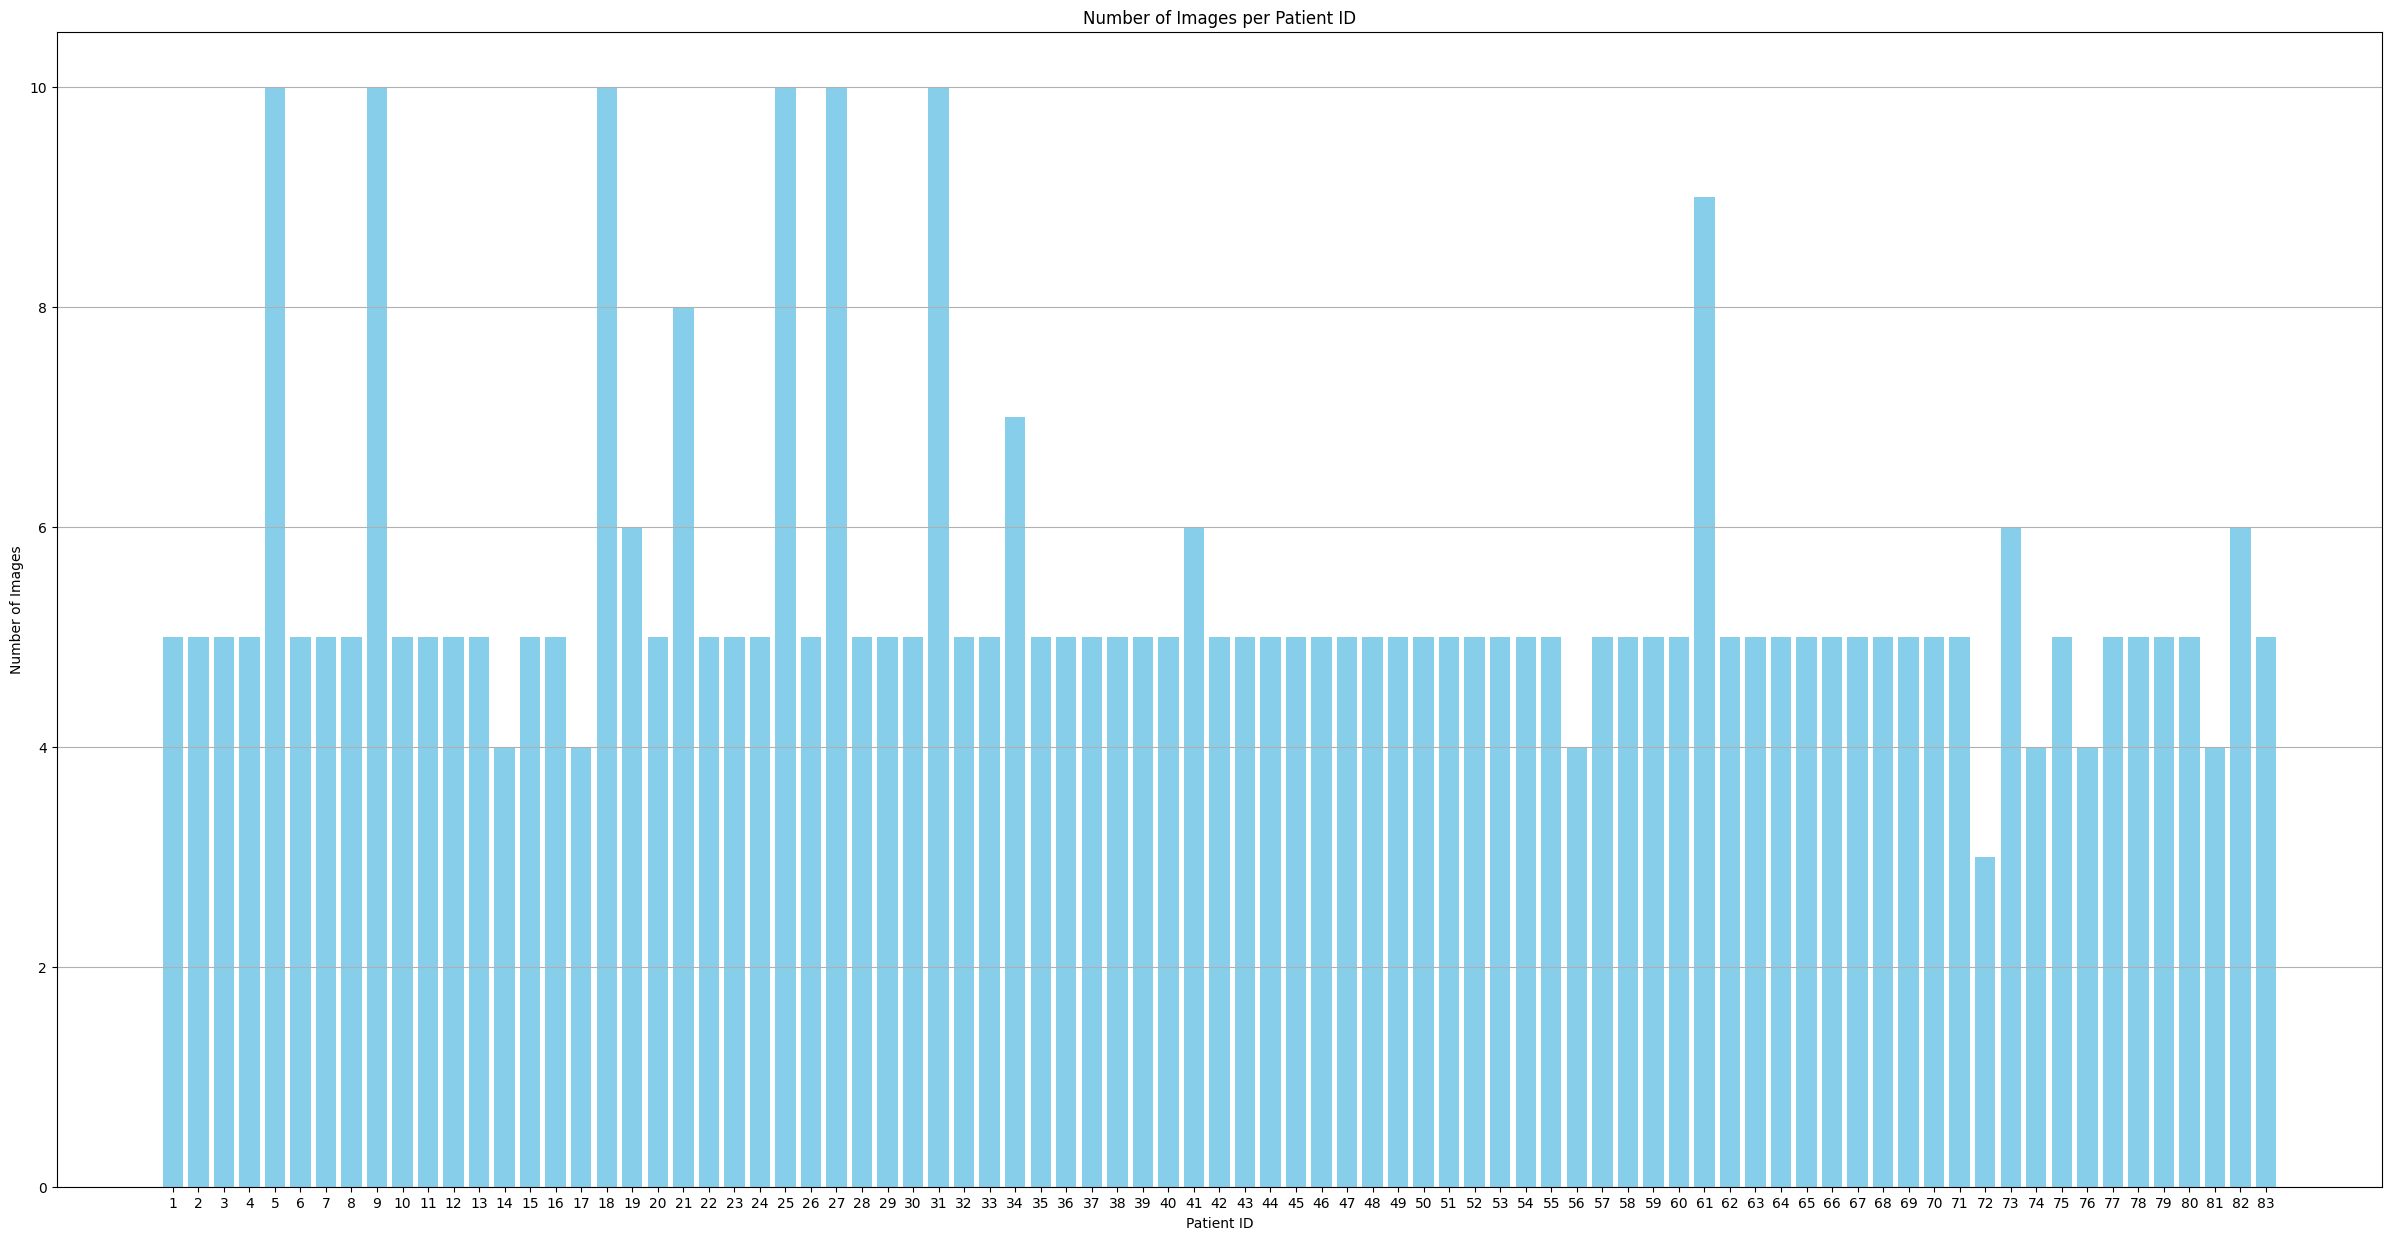

In [16]:
image_counts = df['patient_ID'].value_counts().sort_index()

plt.figure(figsize=(30, 15))
plt.bar(image_counts.index, image_counts.values, color='skyblue')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.title('Number of Images per Patient ID')
plt.xticks(image_counts.index)
plt.grid(axis='y')
plt.show()

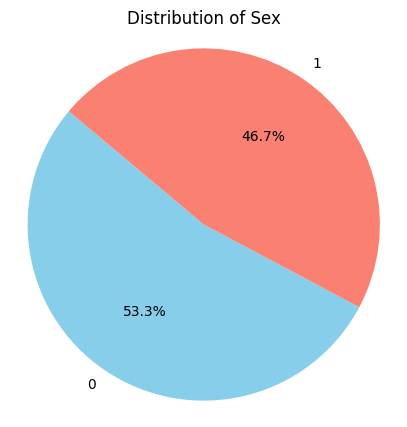

In [17]:
sex_counts = df['sex'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title('Distribution of Sex')
plt.axis('equal') 
plt.show()

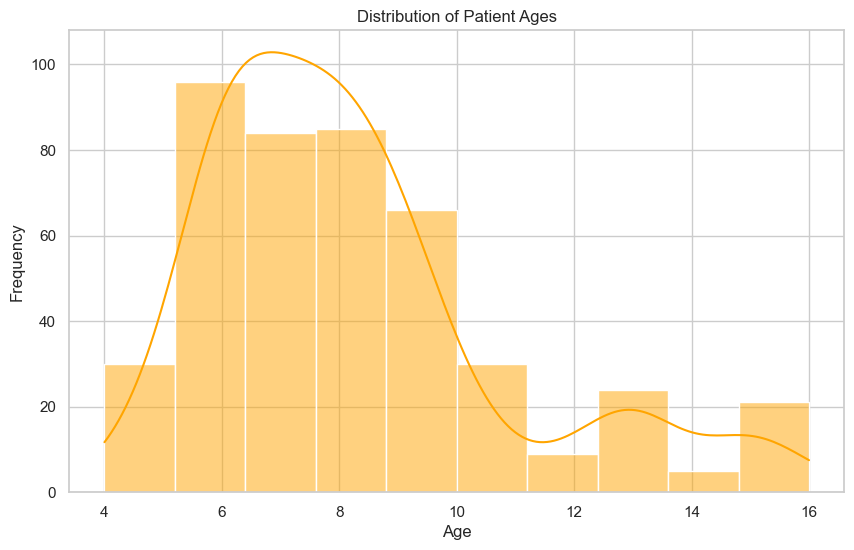

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['age'].dropna(), bins=10, kde=True, color='orange')
plt.title('Distribution of Patient Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

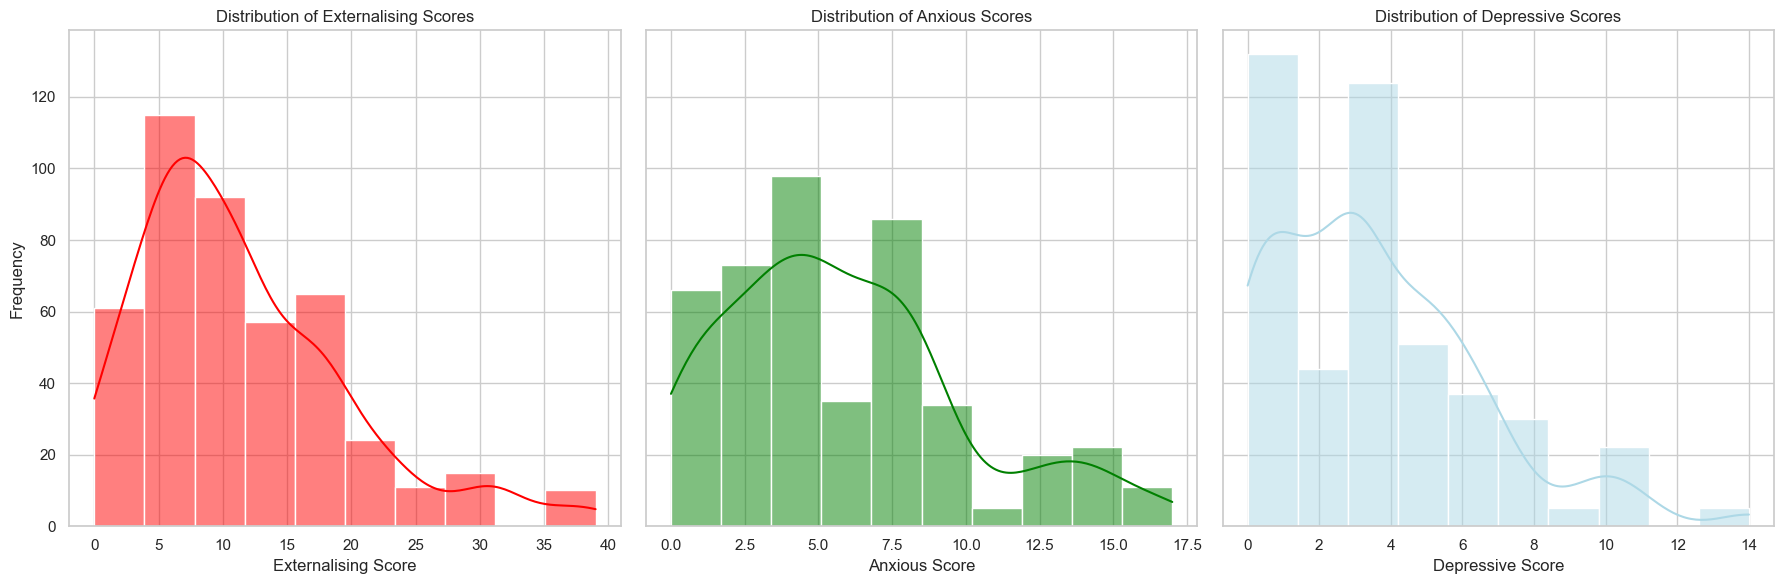

In [19]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

#externalising_score
sns.histplot(df['externalising_score'].dropna(), bins=10, kde=True, color='red', ax=axes[0])
axes[0].set_title('Distribution of Externalising Scores')
axes[0].set_xlabel('Externalising Score')
axes[0].set_ylabel('Frequency')

#anxious_score
sns.histplot(df['anxious_score'].dropna(), bins=10, kde=True, color='green', ax=axes[1])
axes[1].set_title('Distribution of Anxious Scores')
axes[1].set_xlabel('Anxious Score')

#depressive_score
sns.histplot(df['depressive_score'].dropna(), bins=10, kde=True, color='lightblue', ax=axes[2])
axes[2].set_title('Distribution of Depressive Scores')
axes[2].set_xlabel('Depressive Score')

plt.tight_layout()
plt.show()

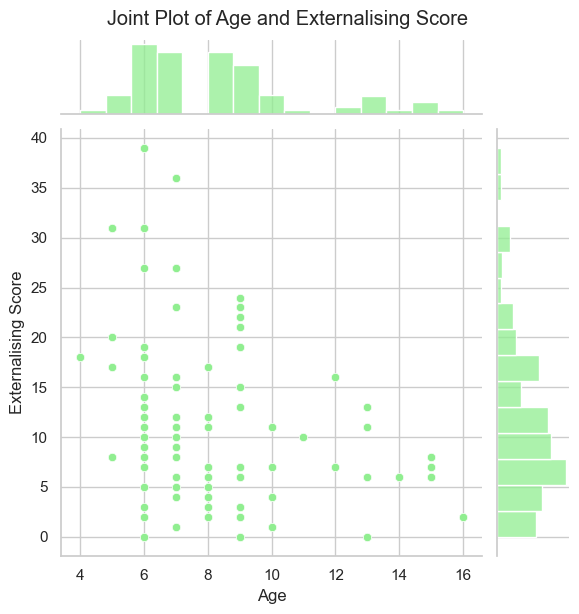

In [20]:
sns.jointplot(x='age', y='externalising_score', data=df, kind='scatter', color='lightgreen', marginal_kws=dict(bins=15, fill=True))
plt.suptitle('Joint Plot of Age and Externalising Score', y=1.02)
plt.xlabel('Age')
plt.ylabel('Externalising Score')
plt.show()

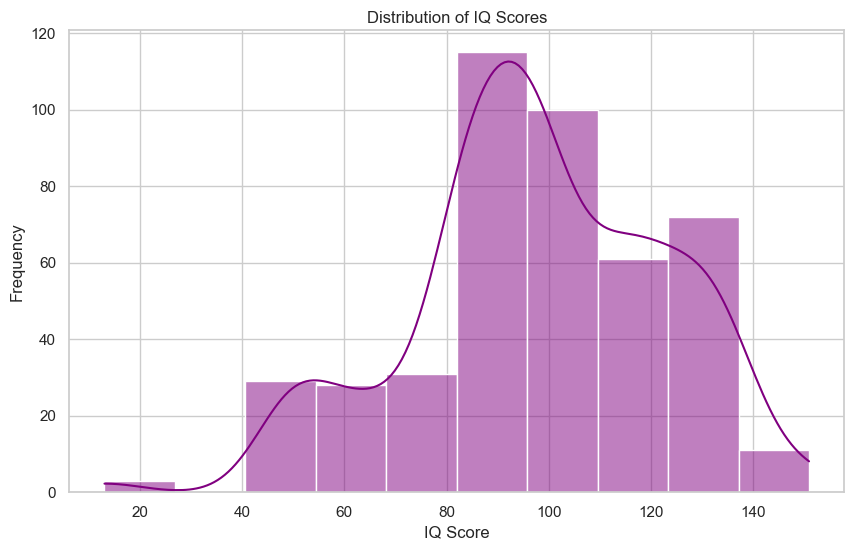

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df['iq_score'].dropna(), bins=10, kde=True, color='purple')
plt.title('Distribution of IQ Scores')
plt.xlabel('IQ Score')
plt.ylabel('Frequency')
plt.show()

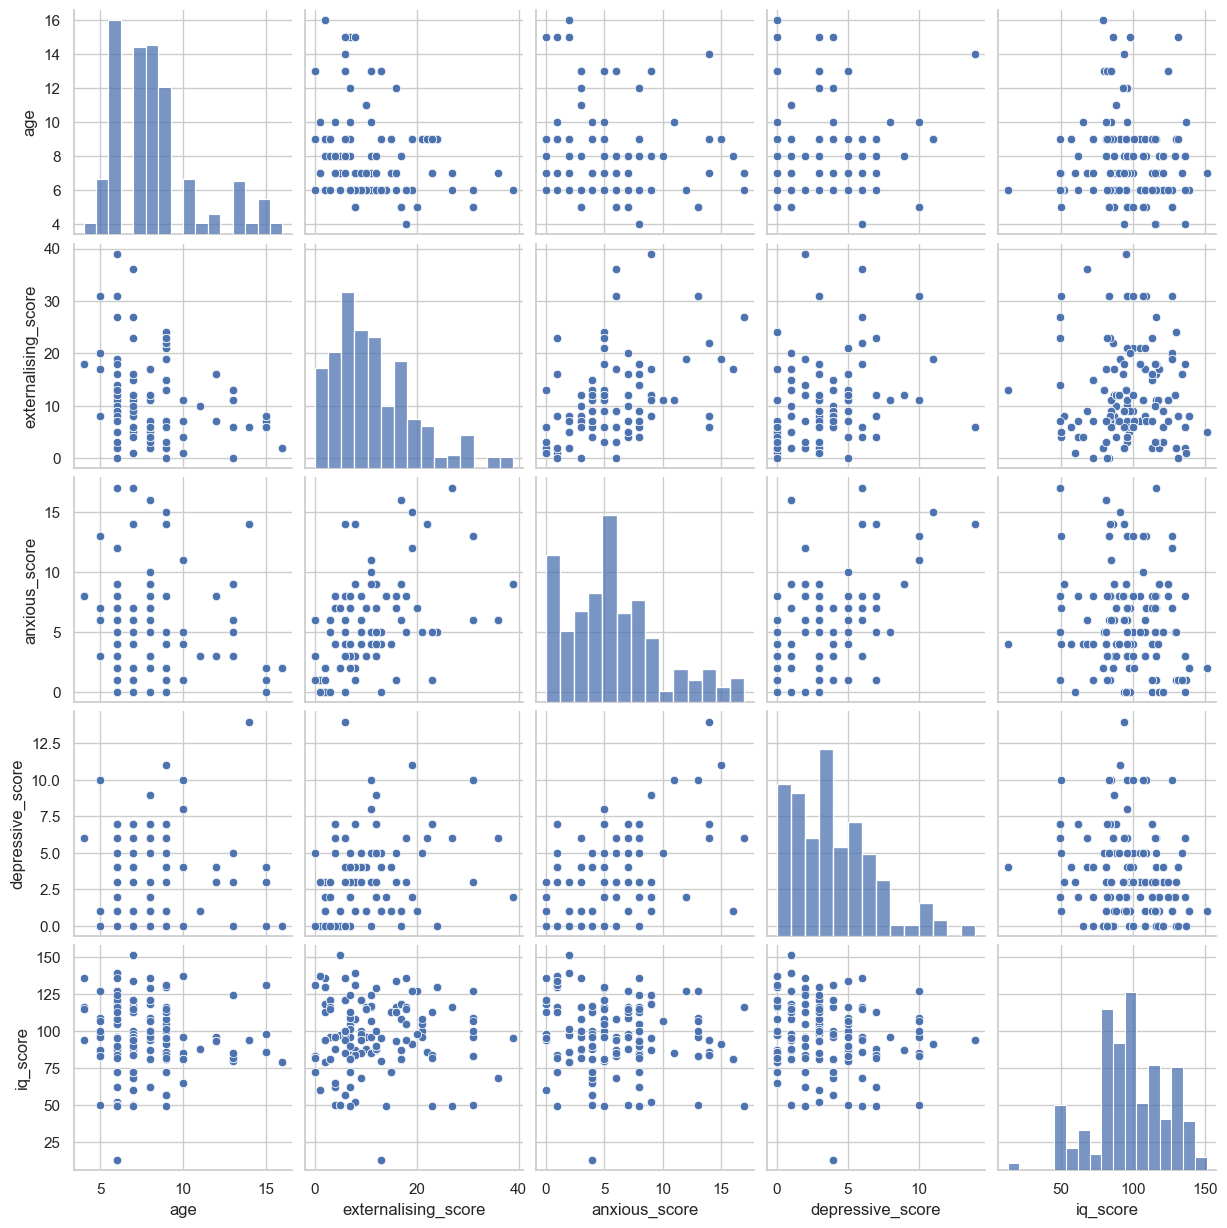

In [22]:
sns.pairplot(df[['age', 'externalising_score', 'anxious_score', 'depressive_score', 'iq_score']])
plt.show()

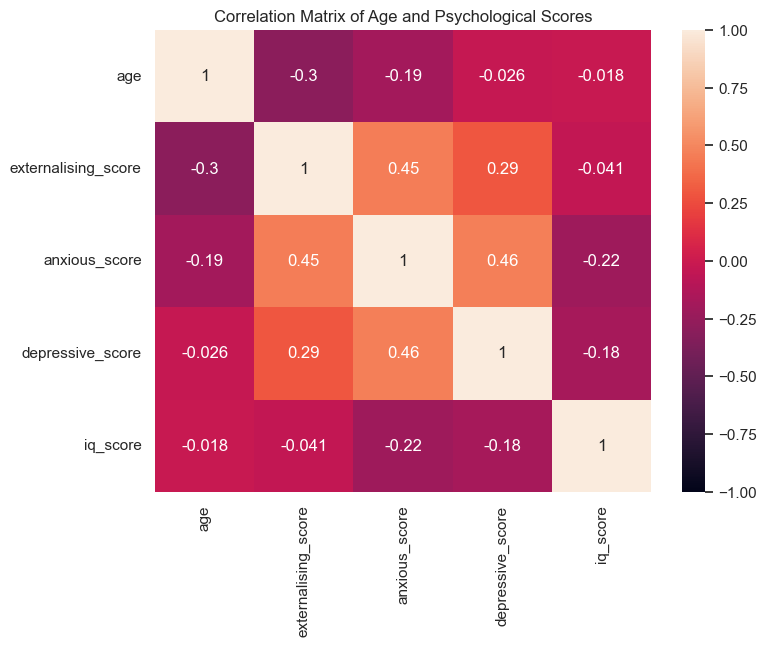

In [23]:
cols = ['age', 'externalising_score', 'anxious_score', 'depressive_score', 'iq_score']
corr_matrix = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Age and Psychological Scores')
plt.show()

## Image Classification

In [24]:
subfolders = ['house', 'tree', 'person']
for folder in subfolders:
    folder_path = os.path.join(img_dataset, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [25]:
target_size = (224, 224)

def preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    return img_array

In [26]:
'''
image_files = [f for f in os.listdir(img_dataset) if f.endswith('.jpg')]
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i in range(num_samples):
    img_filename = image_files[i]
    img_path = os.path.join(img_dataset, img_filename)
    img_array = preprocess_image(img_path, target_size)
    
    axes[i].imshow(img_array)
    axes[i].set_title(f"{img_filename}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
'''

'\nimage_files = [f for f in os.listdir(img_dataset) if f.endswith(\'.jpg\')]\nnum_samples = 5\nfig, axes = plt.subplots(1, num_samples, figsize=(15, 5))\n\nfor i in range(num_samples):\n    img_filename = image_files[i]\n    img_path = os.path.join(img_dataset, img_filename)\n    img_array = preprocess_image(img_path, target_size)\n    \n    axes[i].imshow(img_array)\n    axes[i].set_title(f"{img_filename}")\n    axes[i].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

In [27]:
def move_images_to_folders(image_filenames, labels, source_dir):
 for filename, label in zip(image_filenames, labels):
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(source_dir, label, filename)
        shutil.move(source_path, target_path)

In [28]:
'''
from matplotlib.image import imread


# Example image path
image_path = 'HTPImages/6_1.jpg'

# Load and display the image
img = imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axis ticks and labels
plt.show()
'''

"\nfrom matplotlib.image import imread\n\n\n# Example image path\nimage_path = 'HTPImages/6_1.jpg'\n\n# Load and display the image\nimg = imread(image_path)\nplt.imshow(img)\nplt.axis('off')  # Hide axis ticks and labels\nplt.show()\n"

In [29]:
move_images_to_folders(
    ['1_1.jpg', '1_2.jpg', '1_3.jpg', '1_4.jpg', '1_5.jpg', 
     '2_1.jpg', '2_2.jpg', '2_3.jpg', '2_4.jpg', '2_5.jpg', 
     '3_1.jpg', '3_2.jpg', '3_3.jpg', '3_4.jpg', '3_5.jpg',
     '4_1.jpg', '4_2.jpg', '4_3.jpg', '4_4.jpg', '4_5.jpg', 
     '5_1.jpg', '5_3.jpg', '5_5.jpg', '5_7.jpg', '5_9.jpg',
     '6_1.jpg', '6_2.jpg', '6_3.jpg', '6_4.jpg', '6_5.jpg',
     '7_1.jpg', '7_2.jpg', '7_3.jpg', '7_4.jpg', '7_5.jpg',
     '8_1.jpg', '8_2.jpg', '8_3.jpg', '8_4.jpg', '8_5.jpg',
     '9_1.jpg', '9_3.jpg', '9_5.jpg', '9_7.jpg', '9_9.jpg',
     '10_1.jpg', '10_2.jpg', '10_3.jpg', '10_4.jpg', '10_5.jpg'],
    ['house', 'tree', 'person', 'person', 'person', 
     'house', 'tree', 'person', 'person', 'person', 
     'person', 'house', 'house', 'person', 'tree' ,
     'house', 'tree', 'person', 'person', 'person', 
     'house', 'tree', 'person', 'person', 'person',
     'person', 'tree', 'person', 'person', 'person',
     'house', 'tree', 'person', 'person', 'person',
     'house', 'tree', 'person', 'person', 'person',
     'house', 'tree', 'person', 'person', 'person',
     'person', 'person', 'person', 'house', 'tree'],
    img_dataset
)


In [30]:
base_path = 'HTPImages'
new_base_path = os.path.join(base_path, 'labels')

if not os.path.exists(new_base_path):
    os.makedirs(new_base_path)

subfolders = ['house', 'tree', 'person']

for subfolder in subfolders:
    old_path = os.path.join(base_path, subfolder)
    new_path = os.path.join(new_base_path, subfolder)
    if os.path.exists(old_path):
        shutil.move(old_path, new_path)
        print(f"Moved {subfolder} to labels directory.")
    else:
        print(f"{subfolder} does not exist in {base_path}.")

print("Subfolders moved successfully.")

Moved house to labels directory.
Moved tree to labels directory.
Moved person to labels directory.
Subfolders moved successfully.


In [31]:
base_path = 'HTPImages/labels'

def augment_images(directory, target_count=50):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for subfolder in ['house', 'tree', 'person']:
        subfolder_path = os.path.join(directory, subfolder)
        image_files = os.listdir(subfolder_path)
        
        while len(image_files) < target_count:
            for img_file in image_files:
                img_path = os.path.join(subfolder_path, img_file)
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                
                i = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=subfolder_path, save_prefix=subfolder, save_format='jpg'):
                    i += 1
                    if i >= 1:
                        break
                image_files = os.listdir(subfolder_path)  # Update the list of files
                if len(image_files) >= target_count:
                    break

augment_images(base_path)


In [32]:
def get_images(directory):
    Images = []
    Labels = [] 
    
    for labels in os.listdir(directory):
        for image_file in os.listdir(os.path.join(directory, labels)):
            image = cv2.imread(os.path.join(directory, labels, image_file))
            image = cv2.resize(image, (224, 224))
            Images.append(image)
            Labels.append(labels)
    
    return shuffle(Images, Labels, random_state=817328462) 

Images, Labels = get_images(base_path)

Images = np.array(Images) 
Labels = np.array(Labels)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Labels)

X_train, X_test, y_train, y_test = train_test_split(Images, encoded_labels, test_size=0.2, random_state=42)

print(Counter(encoded_labels))

Counter({2: 50, 0: 50, 1: 50})


### ResNet50

In [33]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = resnet_base.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=predictions)

for layer in resnet_base.layers:
    layer.trainable = False

resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [34]:
training_history_resnet = resnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

2024-06-27 10:54:33.174931: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
4/4 [==============================] - 142s 41s/step - loss: 3.1449 - accuracy: 0.3083 - val_loss: 1.7854 - val_accuracy: 0.4667
Epoch 2/10
4/4 [==============================] - 194s 46s/step - loss: 1.1338 - accuracy: 0.5833 - val_loss: 0.8515 - val_accuracy: 0.5667
Epoch 3/10
4/4 [==============================] - 192s 48s/step - loss: 0.1901 - accuracy: 0.9417 - val_loss: 0.9749 - val_accuracy: 0.6000
Epoch 4/10
4/4 [==============================] - 177s 51s/step - loss: 0.0550 - accuracy: 0.9917 - val_loss: 0.7742 - val_accuracy: 0.6333
Epoch 5/10
4/4 [==============================] - 222s 57s/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.7464 - val_accuracy: 0.6333
Epoch 6/10
4/4 [==============================] - 181s 48s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.8334 - val_accuracy: 0.7333
Epoch 7/10
4/4 [==============================] - 168s 47s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.8969 - val_accuracy: 0.7667
Epoch 8/10
4/4 [====

1/1 [==============================] - 1s 1s/step - loss: 0.8616 - accuracy: 0.7333
Train accuracy: 1.0
Test accuracy: 0.7333333492279053


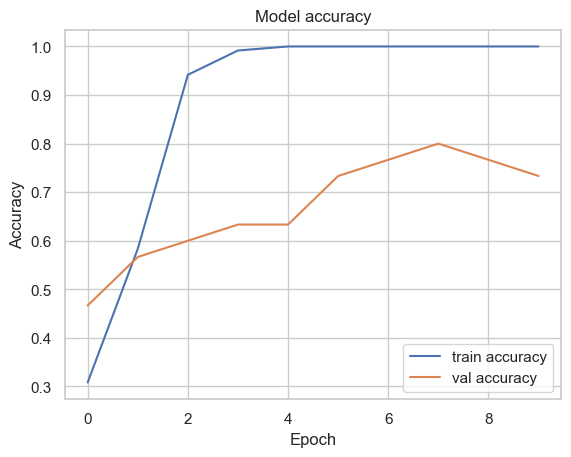

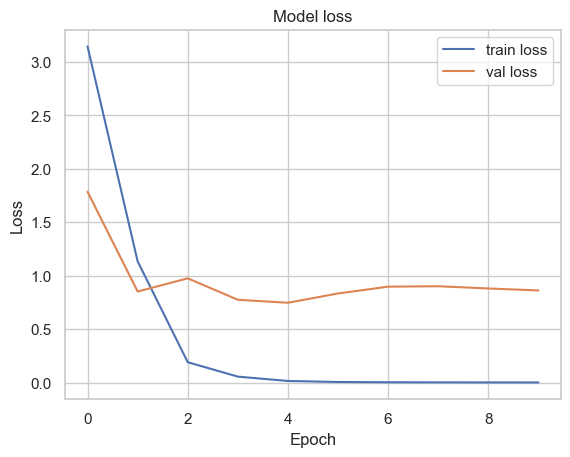

In [35]:
train_loss, train_accuracy = resnet_model.evaluate(X_train, y_train)
test_loss, test_accuracy = resnet_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.plot(training_history_resnet.history['accuracy'], label='train accuracy')
plt.plot(training_history_resnet.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_resnet.history['loss'], label='train loss')
plt.plot(training_history_resnet.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### VGG16

In [36]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg_base.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base.input, outputs=predictions)

for layer in vgg_base.layers:
    layer.trainable = False

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [40]:
training_history_vgg = vgg_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
4/4 [==============================] - 13s 3s/step - loss: 3.5508e-04 - accuracy: 1.0000 - val_loss: 1.5669 - val_accuracy: 0.6333
Epoch 2/10
4/4 [==============================] - 13s 3s/step - loss: 3.1290e-04 - accuracy: 1.0000 - val_loss: 1.5767 - val_accuracy: 0.6333
Epoch 3/10
4/4 [==============================] - 13s 3s/step - loss: 2.6139e-04 - accuracy: 1.0000 - val_loss: 1.5784 - val_accuracy: 0.6333
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 2.2199e-04 - accuracy: 1.0000 - val_loss: 1.5770 - val_accuracy: 0.6333
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 1.8734e-04 - accuracy: 1.0000 - val_loss: 1.5743 - val_accuracy: 0.6333
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 1.6503e-04 - accuracy: 1.0000 - val_loss: 1.5711 - val_accuracy: 0.6333
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 1.4239e-04 - accuracy: 1.0000 - val_loss: 1.5680 - val_accuracy: 0.6333
Epoch 

1/1 [==============================] - 2s 2s/step - loss: 1.5631 - accuracy: 0.6333
Train accuracy: 1.0
Test accuracy: 0.6333333253860474


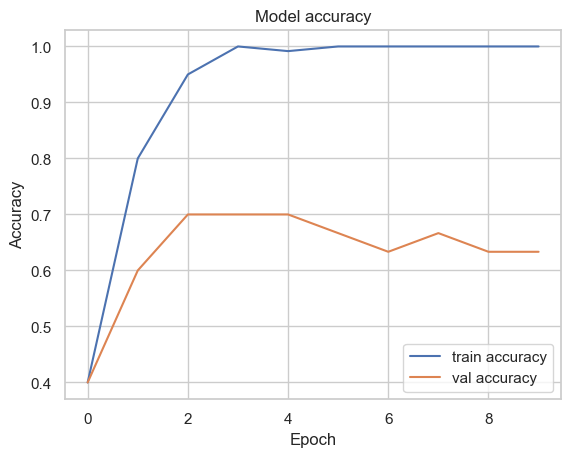

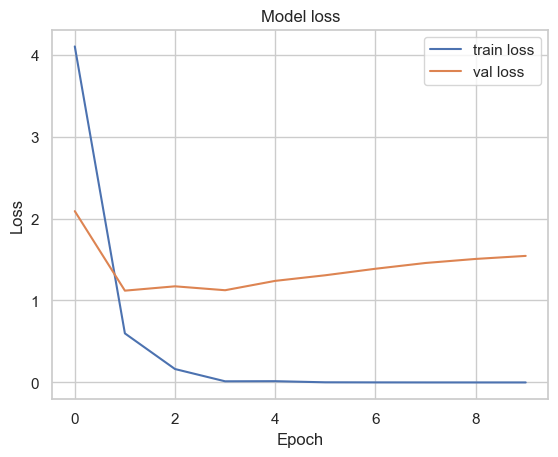

In [41]:
train_loss, train_accuracy = vgg_model.evaluate(X_train, y_train)
test_loss, test_accuracy = vgg_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.plot(training_history_resnet.history['accuracy'], label='train accuracy')
plt.plot(training_history_resnet.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_resnet.history['loss'], label='train loss')
plt.plot(training_history_resnet.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### EfficientNet

In [42]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = efficientnet_base.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

efficientnet_model = Model(inputs=efficientnet_base.input, outputs=predictions)

for layer in efficientnet_base.layers:
    layer.trainable = False

efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

efficientnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [43]:
training_history_efficientnet = efficientnet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
4/4 [==============================] - 11s 2s/step - loss: 1.3760 - accuracy: 0.3417 - val_loss: 0.9551 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 0.2640 - accuracy: 0.9083 - val_loss: 0.7729 - val_accuracy: 0.6333
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 0.0370 - accuracy: 0.9917 - val_loss: 0.6730 - val_accuracy: 0.7333
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.7344 - val_accuracy: 0.8000
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7546 - val_accuracy: 0.8000
Epoch 6/10
4/4 [==============================] - 5s 1s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.7637 - val_accuracy: 0.8333
Epoch 7/10
4/4 [==============================] - 5s 1s/step - loss: 4.9234e-04 - accuracy: 1.0000 - val_loss: 0.7630 - val_accuracy: 0.8333
Epoch 8/10
4/4 [====================

1/1 [==============================] - 0s 425ms/step - loss: 0.7614 - accuracy: 0.8333
Train accuracy: 1.0
Test accuracy: 0.8333333134651184


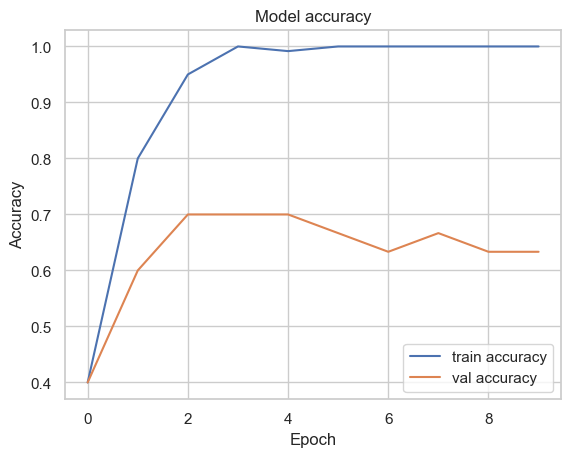

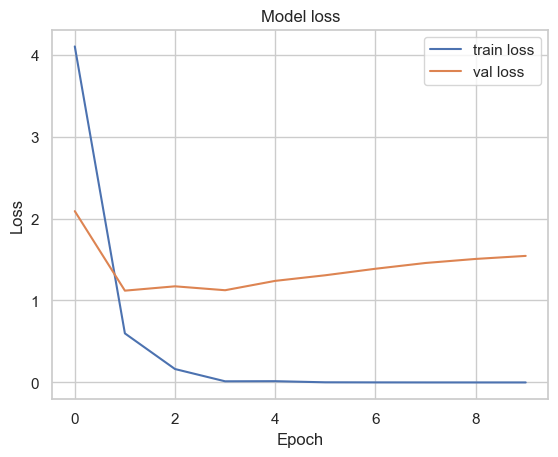

In [44]:
train_loss, train_accuracy = efficientnet_model.evaluate(X_train, y_train)
test_loss, test_accuracy = efficientnet_model.evaluate(X_test, y_test)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Plot training history
plt.plot(training_history_resnet.history['accuracy'], label='train accuracy')
plt.plot(training_history_resnet.history['val_accuracy'], label='val accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(training_history_resnet.history['loss'], label='train loss')
plt.plot(training_history_resnet.history['val_loss'], label='val loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [45]:
def evaluate_model(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    print(classification_report(y_test, y_pred))

print("VGG16 Model Performance")
evaluate_model(vgg_model, X_test, y_test)

print("ResNet50 Model Performance")
evaluate_model(resnet_model, X_test, y_test)

print("EfficientNet Model Performance")
evaluate_model(efficientnet_model, X_test, y_test)

VGG16 Model Performance
1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.78      0.58      0.67        12
           2       0.64      0.64      0.64        11

    accuracy                           0.63        30
   macro avg       0.64      0.64      0.63        30
weighted avg       0.66      0.63      0.64        30

ResNet50 Model Performance
1/1 [==============================] - 8s 8s/step
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.77      0.83      0.80        12
           2       1.00      0.45      0.62        11

    accuracy                           0.73        30
   macro avg       0.78      0.76      0.72        30
weighted avg       0.81      0.73      0.72        30

EfficientNet Model Performance
1/1 [==============================] - 6s 6s/step
      

In [46]:
training_histories = {
    'VGG16': training_history_vgg,
    'ResNet50': training_history_resnet,
    'EfficientNetB0': training_history_efficientnet
}

In [47]:
def plot_training_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 8))
    
    for model, history in histories.items():
        plt.plot(history.history[metric], label=f'{model} Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'{model} Validation {metric.capitalize()}')

    plt.title(f'Model {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

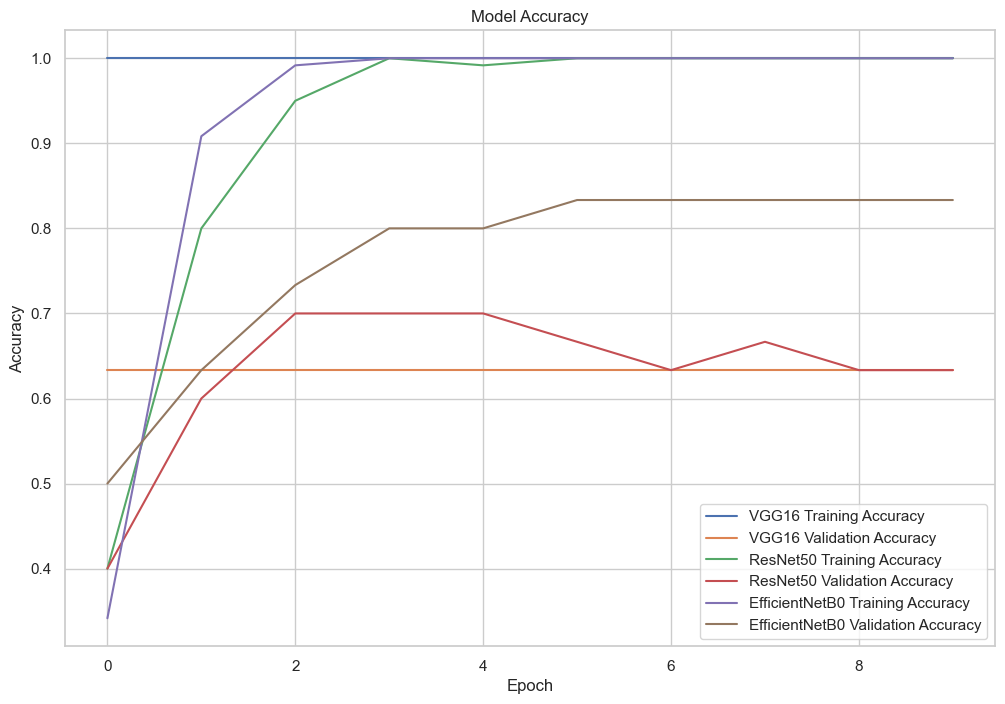

In [48]:
plot_training_history(training_histories, metric='accuracy')

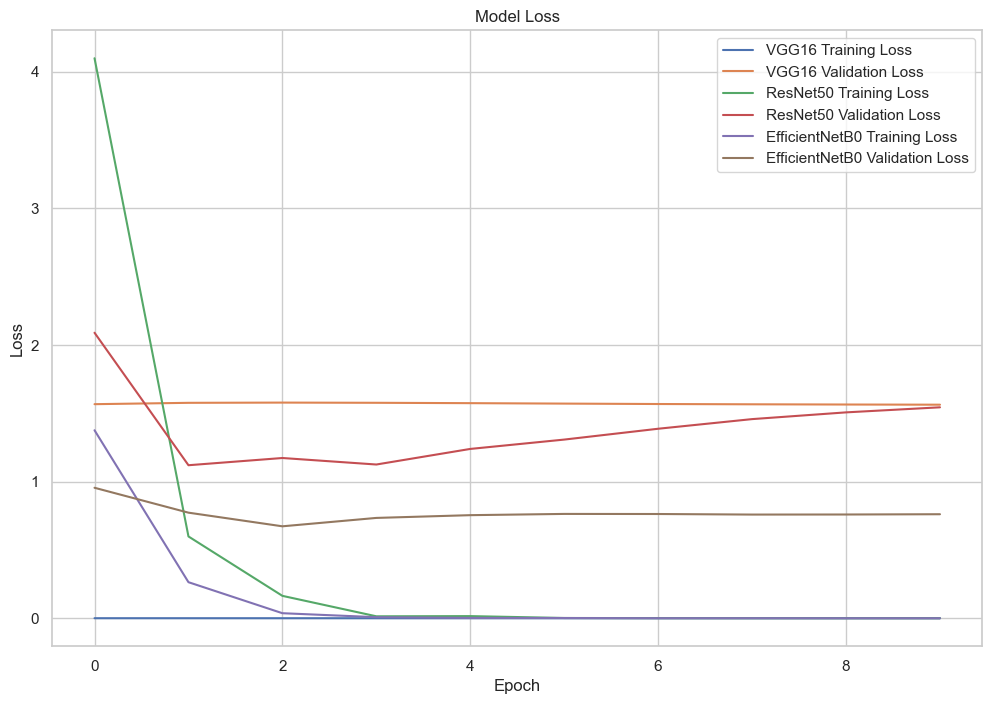

In [49]:
plot_training_history(training_histories, metric='loss')

In [50]:
#Save the model
resnet_model.save("resnet_model.h5")

In [51]:
# Load the model
model = load_model("resnet_model.h5")

In [52]:
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


In [53]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [73]:
dataset_dir= 'HTPImages'
image_files = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        image_files.append(os.path.join(root, file))

random_image_path = random.choice(image_files)

img_array = get_img_array(random_image_path, size = (224,224))

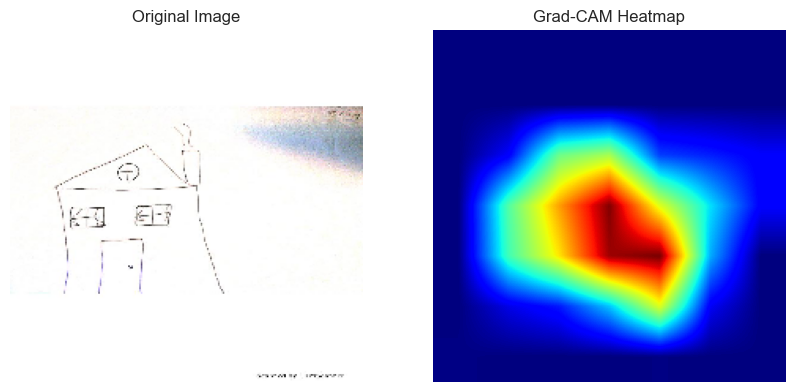

In [74]:
heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")
heatmap_expanded = np.expand_dims(heatmap, axis=(0, -1))
heatmap_resized = tf.image.resize(heatmap_expanded, (img_array.shape[1], img_array.shape[2]))

heatmap_resized = tf.squeeze(heatmap_resized)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_array[0] / 255) 
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()